In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import pandas as pd

from utils import train#, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, plotmesh, merge_weights_aniso
from utils_hyperelasticity import NODE, init_layers

import GPy
#from jaxinterp2d import interp2d

from scipy.optimize import fsolve

In [269]:
@jit
def u_gt_nz(x): # not zero at the boundary
    # this is the integral of a*sigmoid(b*(x-c)) + d strain  
    a = 0.05
    b = 100
    c = 0.5
    d = 0.1
    return (a + d)*x + (a*jnp.log(1 + jnp.exp(b*(c - x))))/(b*jnp.log(jnp.e))

u_gt = jit(lambda x: u_gt_nz(x) - u_gt_nz(0))

n = 40
x_gt = np.linspace(0,1,n)[:,None]
k = GPy.kern.RBF(input_dim=1,lengthscale=0.4)
mu = np.zeros((n)) 
C = k.K(x_gt,x_gt) 
#eps_gt = np.random.multivariate_normal(mu,C,1)*0.03+0.15

x_gt = x_gt.flatten()
eps_gt =  vmap(grad(u_gt))(x_gt).flatten()
np.random.seed(1234)
Fx = np.random.uniform()+0.5

def get_stress_neoHook(x, Lambda_params):
    eps = vmap(grad(u_gt))(x)
    lmb = 1.0+eps
    mu = nn_fpass(x, Lambda_params)
    sgmx = mu*lmb**2 - mu/lmb
    return sgmx[0]
get_stress_neoHook_vmap = vmap(get_stress_neoHook, in_axes=(0,None))

Text(0.5, 1.0, 'Reaction force = 0.692')

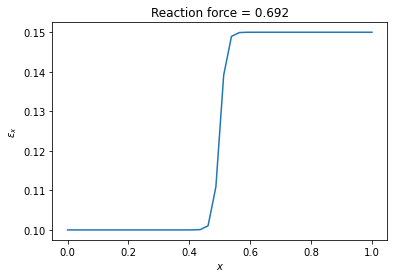

In [270]:
plt.plot(x_gt,eps_gt)
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.title('Reaction force = {}'.format(np.round(Fx, 3)))

### Incompressible neo-Hookean

$$ \Psi(\mathbf{F}, x) = \mu(x)(I_1(x)-3) $$

$$ \boldsymbol{\sigma} = -p\mathbf{I} + \mu \mathbf{b} $$

under uniaxial loading $\lambda_y = \lambda_z = 1/\sqrt{\lambda}, \lambda_x = \lambda$ and $\mathbf{b} = \mathrm{diag}(\lambda^2, 1/\lambda, 1/\lambda)$ then,

$$ p = \frac{\mu}{\lambda} $$ 

from boundary conditions. And finally,

$$ \sigma_{xx} = \mu \lambda^2 - \frac{\mu}{\lambda} $$

In [264]:
def nn_fpass(H, params):
    Ws, bs = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = jnp.matmul(H, Ws[i]) + bs[i]
        H = jnp.tanh(H)
    H = jnp.matmul(H, Ws[-1]) + bs[-1]
    return H

def init_params_nn(layers, key):
    Ws = []
    bs = []
    for i in range(len(layers) - 1):
      std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
      key, subkey = random.split(key)
      Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
      bs.append(jnp.zeros(layers[i + 1]))
    return [Ws, bs]
    


### Loss function: 2 objectives
#### 1. Balance of linear momentum

$$ \nabla \cdot \boldsymbol{\sigma} + \rho \mathbf{f} = 0 $$

in the absence of body forces $\mathbf{f}$ and in 1D this becomes

$$ \frac{\partial \sigma_{xx}}{\partial x} = 0 $$


#### 2. Satisfying reaction forces

$$ \int_{\text{bd}} \sigma_{xx} dA = F_{\text{react.}} $$

Then the loss function is defined as

$$ L(\phi) = \left( \frac{\partial \sigma_{xx}}{\partial x} \right)^2 + (\sigma_{xx}(0) \cdot A - F_{\text{react.}})^2 + (\sigma_{xx}(L) \cdot A - F_{\text{react.}})^2 $$

In [292]:
divergence_1d = vmap(grad(get_stress_neoHook, argnums=0), in_axes=(0,None), out_axes=0)

def loss(Lambda_params, input, key):
    # get divergence across the domain
    x_colloc = random.uniform(key, (200,1))
    div = divergence_1d(x_colloc, Lambda_params)

    # get stress at 0 & L
    sgm0 = get_stress_neoHook(x_gt[ 0,None], Lambda_params)
    sgmL = get_stress_neoHook(x_gt[-1,None], Lambda_params)
    dmudx = vmap(grad(lambda x: nn_fpass(x[None], Lambda_params)[0]))(x_colloc[:,0])
    TV = jnp.mean(jnp.sqrt(dmudx**2))
    return 1*jnp.sum(div**2) + 10*((sgm0*1 - Fx)**2 + (sgmL*1-Fx)**2) #+ 1e-12*TV# Assuming CS Area = 1


Lambda_layers = [1,3,3,1]
key = random.PRNGKey(0)
Lambda_params = init_params_nn(Lambda_layers, key)
lr = optimizers.exponential_decay(1e-3, 10000, 0.9)
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, metrics = train(loss, None, get_params, opt_update, opt_state, key, nIter = 500000, print_freq=10000)

it 10000, train loss = 8.944991e+00
it 20000, train loss = 8.969120e+00
it 30000, train loss = 8.573139e+00
it 40000, train loss = 7.822921e+00
it 50000, train loss = 3.059294e+00
it 60000, train loss = 2.415082e-03
it 70000, train loss = 2.173692e-04
it 80000, train loss = 7.937517e-05
it 90000, train loss = 2.432744e-04
it 100000, train loss = 9.128142e-05
it 110000, train loss = 9.464825e-05
it 120000, train loss = 1.135141e-04
it 130000, train loss = 1.242706e-04
it 140000, train loss = 9.898964e-05
it 150000, train loss = 1.128978e-04
it 160000, train loss = 1.184701e-04
it 170000, train loss = 7.932562e-05
it 180000, train loss = 1.072598e-04
it 190000, train loss = 1.091501e-04
it 200000, train loss = 1.575392e-04
it 210000, train loss = 1.189677e-04
it 220000, train loss = 9.845145e-05
it 230000, train loss = 1.188354e-04
it 240000, train loss = 1.518553e-04
it 250000, train loss = 9.671516e-05
it 260000, train loss = 1.144310e-04
it 270000, train loss = 1.060394e-04
it 280000,

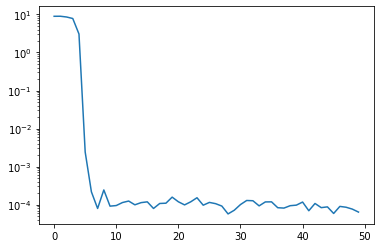

In [293]:
plt.plot(train_loss)
plt.yscale('log')

In [294]:
def get_strain_neoHook(x, Lambda_params): # Invert the get_stress_neoHook function to get the strain for a given stress
    sgmx = Fx/1.0 #stress is constant for the domain
    mu = nn_fpass(x, Lambda_params)
    
    invertsgm = lambda lmb: mu*lmb**2 - mu/lmb - sgmx
    lmb = fsolve(invertsgm, x0 = 1.0)
    return lmb-1.0

eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_neoHook(x_gt[i,None], Lambda_params)[0])

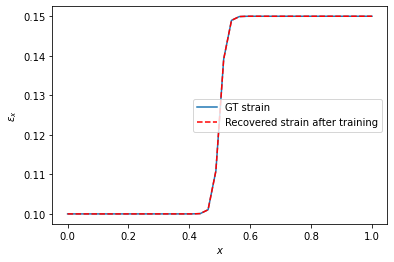

In [295]:
plt.plot(x_gt, eps_gt, label='GT strain')
plt.plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.legend()

(0.5532155603031138, 0.8298233404546708)

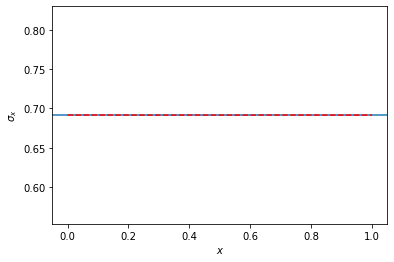

In [296]:
sgm_pr = []
for i in range(len(x_gt)):
    sgm_pr.append(get_stress_neoHook(x_gt[i,None], Lambda_params))
plt.axhline(Fx, label='GT stress')
plt.plot(x_gt, sgm_pr, 'r--', label='Stress calculated after training')
plt.xlabel('$x$')
plt.ylabel('$\sigma_{x}$')
plt.ylim([Fx*0.8, Fx*1.2])

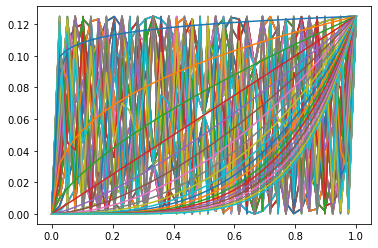

In [200]:
freqs = [jnp.pi/2, 3/2*jnp.pi, 5/2*np.pi]
VFs = []

u_L = u_gt(1.0)

for i in range(100):
    VFs.append(jit(lambda x: u_L*jnp.sin((jnp.pi/2 + jnp.pi*i)*x)**2))
    plt.plot(x_gt, VFs[-1](x_gt))


for coeff in jnp.linspace(1/16,6,20):
    VFs.append(jit(lambda x: u_L*x**coeff))
    plt.plot(x_gt, VFs[-1](x_gt))

In [241]:
divergence_1d = vmap(grad(get_stress_neoHook, argnums=0), in_axes=(0,None), out_axes=0)


x_int = jnp.linspace(0,1,501)
dx = x_int[1] - x_int[0]



def loss(Lambda_params, input, key):
    P = get_stress_neoHook_vmap(x_int[:,None], Lambda_params)
    L = 0.0
    for vf in VFs:
        dvfdx = vmap(grad(vf))(x_int)
        L += (jnp.trapz(P*dvfdx,x_int) - Fx*u_L)**2

    dmudx = vmap(grad(lambda x: nn_fpass(x[None], Lambda_params)[0]))(x_int)
    TV = jnp.mean(jnp.sqrt(dmudx**2))
    return L + 1e-4*TV


Lambda_layers = [1,10,10,1]
key = random.PRNGKey(0)
Lambda_params = init_params_nn(Lambda_layers, key)

opt_init, opt_update, get_params = optimizers.adam(1.e-3)
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, metrics = train(loss, None, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=1000)

it 1000, train loss = 1.106655e-02
it 2000, train loss = 2.462829e-04
it 3000, train loss = 2.379773e-04
it 4000, train loss = 2.375735e-04
it 5000, train loss = 2.369008e-04
it 6000, train loss = 2.357825e-04
it 7000, train loss = 2.339060e-04
it 8000, train loss = 2.306499e-04
it 9000, train loss = 2.244494e-04
it 10000, train loss = 2.100727e-04
it 11000, train loss = 1.788829e-04
it 12000, train loss = 1.489181e-04
it 13000, train loss = 1.477469e-04
it 14000, train loss = 1.476550e-04
it 15000, train loss = 1.475498e-04
it 16000, train loss = 1.500665e-04
it 17000, train loss = 1.473072e-04
it 18000, train loss = 1.473142e-04
it 19000, train loss = 1.470041e-04
it 20000, train loss = 1.468615e-04
it 21000, train loss = 1.483873e-04
it 22000, train loss = 1.503475e-04
it 23000, train loss = 1.465087e-04
it 24000, train loss = 1.464462e-04
it 25000, train loss = 1.464388e-04
it 26000, train loss = 1.465014e-04
it 27000, train loss = 1.464307e-04
it 28000, train loss = 1.464266e-04
i

In [243]:
P = get_stress_neoHook_vmap(x_int[:,None], Lambda_params)
for vf in VFs:
    dvfdx = vmap(grad(vf))(x_int)
    print((jnp.trapz(P*dvfdx,x_int)))

0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284
0.08641150136651284


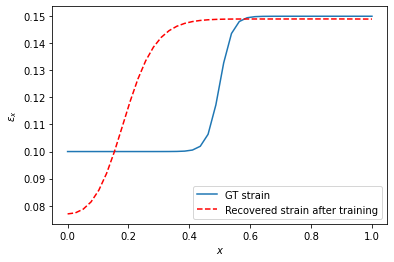

In [244]:
eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_neoHook(x_gt[i,None], Lambda_params)[0])

plt.plot(x_gt, eps_gt, label='GT strain')
plt.plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.legend()

(0.5532155603031138, 0.8298233404546708)

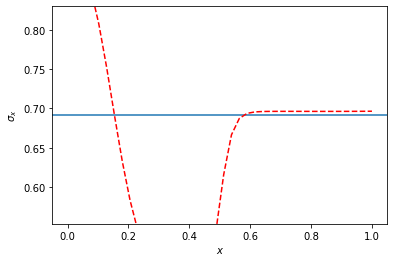

In [245]:
sgm_pr = []
for i in range(len(x_gt)):
    sgm_pr.append(get_stress_neoHook(x_gt[i,None], Lambda_params))
plt.axhline(Fx, label='GT stress')
plt.plot(x_gt, sgm_pr, 'r--', label='Stress calculated after training')
plt.xlabel('$x$')
plt.ylabel('$\sigma_{x}$')
plt.ylim([Fx*0.8, Fx*1.2])


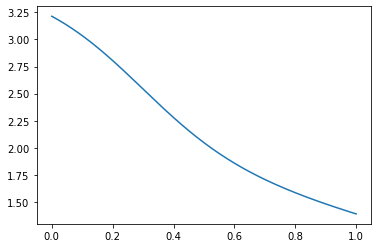

In [240]:
dmudx = vmap(grad(lambda x: nn_fpass(x[None], Lambda_params)[0]))(x_int)
mu = vmap(lambda x: nn_fpass(x[None], Lambda_params)[0])(x_int)

plt.plot(x_int,mu)



#### Neural ODE

In [16]:
def get_stress_node(x, Lambda_params):
    eps = jnp.interp(x, x_gt, eps_gt)
    lmb = 1.0+eps
    I1 = lmb**2 + 1/lmb + 1/lmb
    phi = nn_fpass(x, Lambda_params)
    Psi1 = NODE(I1, unravel(phi))
    sgmx = Psi1*(lmb**2 - 1/lmb)
    return sgmx[0]
get_stress_node_vmap = vmap(get_stress_node, in_axes=(0,None), out_axes=(0,))
divergence_1d = vmap(grad(get_stress_node, argnums=0), in_axes=(0,None), out_axes=0)

def loss(Lambda_params, input, key):
    # get divergence across the domain
    x_colloc = random.uniform(key, (20,1))
    div = divergence_1d(x_colloc, Lambda_params)

    # get stress at 0 & L
    sgm0 = get_stress_node(x_gt[ 0,None], Lambda_params)
    sgmL = get_stress_node(x_gt[-1,None], Lambda_params)
    return 1*jnp.sum(div**2) + 10*((sgm0*1 - Fx)**2 + (sgmL*1-Fx)**2) # Assuming CS Area = 1


common_layers = [1,3,3]
sample_layers = [3,1]
clayers = init_layers(common_layers, key)
slayers = init_layers(sample_layers, key) # I don't really want to do common layers and sample layers here, but I didn't want to modify my functions to accept a single set of layers.
dummy_phi = (clayers, slayers) 
aux, unravel = ravel_pytree(dummy_phi)

n_params = len(aux)
Lambda_layers = [1,3,3,n_params]
key = random.PRNGKey(0)
Lambda_params = init_params_nn(Lambda_layers, key)

opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, metrics = train(loss, None, get_params, opt_update, opt_state, key, nIter = 200000, print_freq=10000)

it 10000, train loss = 1.825184e+00
it 20000, train loss = 2.954533e-01
it 30000, train loss = 6.951303e-02
it 40000, train loss = 6.817799e-02
it 50000, train loss = 6.665500e-02
it 60000, train loss = 7.404357e-02
it 70000, train loss = 9.924636e-02
it 80000, train loss = 7.503205e-02
it 90000, train loss = 5.188343e-02
it 100000, train loss = 7.308079e-02
it 110000, train loss = 3.869415e-02
it 120000, train loss = 7.680376e-02
it 130000, train loss = 4.995370e-02
it 140000, train loss = 7.158010e-02
it 150000, train loss = 7.158459e-02
it 160000, train loss = 8.119065e-02
it 170000, train loss = 7.788287e-02
it 180000, train loss = 5.878439e-02
it 190000, train loss = 1.025152e-01
it 200000, train loss = 4.992751e-02


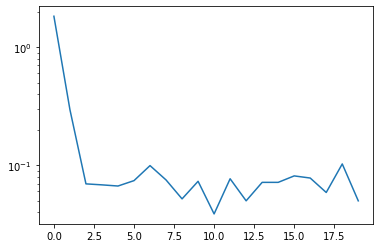

In [17]:
plt.plot(train_loss)
plt.yscale('log')

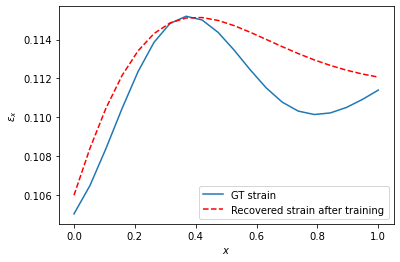

In [18]:
def get_strain_node(x, Lambda_params): # Invert the get_stress_neoHook function to get the strain for a given stress
    sgmx = Fx/1.0 #stress is constant for the domain
    phi = nn_fpass(x, Lambda_params)
    
    def invertsgm(lmb):
        I1 = lmb**2 + 1/lmb + 1/lmb
        Psi1 = NODE(I1, unravel(phi))
        return Psi1*(lmb**2 - 1/lmb) - sgmx
    lmb = fsolve(invertsgm, x0 = 1.0)
    return lmb-1.0

eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_node(x_gt[i,None], Lambda_params)[0])


plt.plot(x_gt, eps_gt, label='GT strain')
plt.plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.legend()

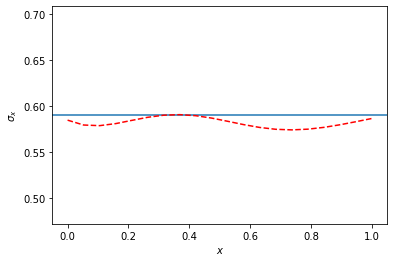

In [19]:
sgm_pr = []
for i in range(len(x_gt)):
    sgm_pr.append(get_stress_node(x_gt[i,None], Lambda_params))
plt.axhline(Fx, label='GT stress')
plt.plot(x_gt, sgm_pr, 'r--', label='Stress calculated after training')
plt.xlabel('$x$')
plt.ylabel('$\sigma_{x}$')
plt.ylim([Fx*0.8, Fx*1.2]); 